# Introduction to PCA

Part 1: PCA in pure NumPy

Part 2: Adapted from http://www.science.smith.edu/~jcrouser/SDS293/labs/

## Setup

In [1]:
# imports and setup
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 4) # number precision for pandas
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.5f}'.format) # get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

# PCA in Pure Numpy

### Create simple toy dataset in 2D

In [2]:
x = 0.5 * np.random.randn(100)
y = 1.0 * x + 0.2 * np.random.randn(100)

(-2, 2)

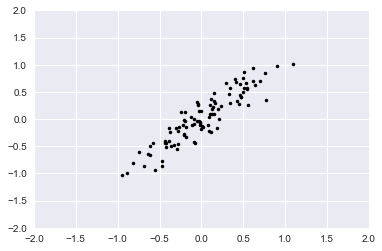

In [3]:
plt.plot(x,y, 'k.');
plt.xlim([-2, 2]); 
plt.ylim([-2, 2])

In [4]:
x_NF = np.hstack([x[:,np.newaxis], y[:,np.newaxis]])
N = x_NF.shape[0]

print(N)

100


# Step-by-step approach to applying PCA

In [5]:
# Zero-center the data
mu_F = np.mean(x_NF, axis=0)
xc_NF = x_NF - mu_F[np.newaxis,:]


In [6]:
# Compute covariance matrix
cov_FF = np.dot(xc_NF.T, xc_NF) / N
cov2_FF = np.cov(x_NF.T, bias=1)
assert np.allclose(cov_FF, cov2_FF)

In [7]:
# Find eigenvalues/vectors
eig_vals_F, v_FF = np.linalg.eig(cov_FF)
print("shape of eig_vals_F: %s" % eig_vals_F.shape)
print("shape of v_FF: %s" % str(v_FF.shape))


shape of eig_vals_F: 2
shape of v_FF: (2, 2)


In [8]:
# Select top K eigenvectors
K = 1

In [9]:
sort_ids_F = np.argsort(eig_vals_F)[::-1] # sort eigenvalues largest to smallest
sort_ids_K = sort_ids_F[:K]

eig_vals_K = eig_vals_F[sort_ids_K]
v_FK = v_FF[:, sort_ids_K]

In [10]:
eig_vals_K

array([0.38496733])

In [11]:
v_FK

array([[-0.6527781 ],
       [-0.75754917]])

# Show the first eigen vector along with data

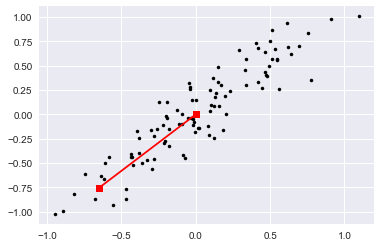

In [12]:
plt.plot(x_NF[:,0], x_NF[:,1], 'k.');
plt.plot([0,v_FK[0]], [0,v_FK[1]], 'rs-');

# PCA: Each step wrapped in a function

In [13]:
def calculate_pca(x_NF, K=1):
    mu_F = np.mean(x_NF, axis=0)

    # Zero-center the data
    xc_NF = x_NF - mu_F[np.newaxis,:]

    # Compute covariance matrix
    cov_FF = np.dot(xc_NF.T, xc_NF) / N

    eig_vals_F, v_FF = np.linalg.eig(cov_FF) # Find eigenvalues/vectors: can be slow!
    sort_ids_F = np.argsort(eig_vals_F)[::-1] # sort eigenvalues largest to smallest
    sort_ids_K = sort_ids_F[:K]

    eig_vals_K = eig_vals_F[sort_ids_K]
    v_FK = v_FF[:, sort_ids_K]
    return eig_vals_K, v_FK, mu_F

# Project: From 2D to 1D

In [14]:
def project(x_NF, mu_F, eig_vals_K, v_FK):
    xc_NF = x_NF - mu_F[np.newaxis,:]
    return np.dot(xc_NF, v_FK) * eig_vals_K[np.newaxis,:]


# Reconstruct: From 1D to 2D

In [15]:
def reconstruct(z_NK, mu_F, eig_vals_K, v_FK):
    return mu_F[np.newaxis,:] + np.dot(z_NK, v_FK.T * 1.0/eig_vals_K[:,np.newaxis])

# Show example with non-centered data

In [16]:
x1 = -2.0 + np.random.randn(100)
x2 = 3.0 * x1 + 0.5 * np.random.randn(100)
x_NF = np.hstack([x1[:,np.newaxis], x2[:,np.newaxis]])

In [17]:
eig_vals_K, v_FK, mu_F = calculate_pca(x_NF)

In [18]:
z_NK = project(x_NF, mu_F, eig_vals_K, v_FK)

In [19]:
x2_NF = reconstruct(z_NK, mu_F, eig_vals_K, v_FK)

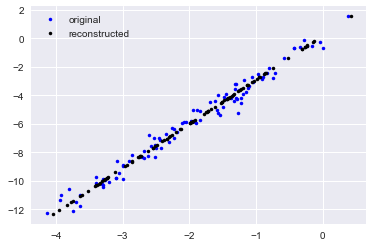

In [20]:
plt.plot(x_NF[:,0], x_NF[:,1], 'b.', label='original')
plt.plot(x2_NF[:,0], x2_NF[:,1], 'k.', label='reconstructed')
plt.legend()

# 6.7.1 Principal Components Regression

In [21]:
from sklearn.preprocessing import scale 
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

/Users/mhughes/anaconda2/envs/comp135_env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
pca = PCA()
X_pca = pca.fit_transform(scale(X))
pd.DataFrame(X_pca)

NameError: name 'X' is not defined

In [ ]:
# 10-fold CV, with shuffle
n = len(X_pca)
k10 = KFold(n, n_folds=10, shuffle=True, random_state=42)

lin_reg = LinearRegression()
rmse = []

# MSE with only the intercept
score = -1 * cross_val_score(lin_reg, np.ones((n,1)), y, cv=k10, scoring='neg_mean_squared_error').mean()
rmse.append(np.sqrt(score))

# MSE for the 19 principle components
for i in np.arange(1, 20):
    score = -1 * cross_val_score(lin_reg, X_pca[:,:i], y, cv=k10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))
    
min_rmse = np.array(rmse).argmin()
    
plt.plot(rmse, '-D')
plt.plot(rmse, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE');

In [ ]:
np.cumsum(pca.explained_variance_ratio_*100)

In [ ]:
# validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

pca2 = PCA()
X_train_pca2 = pca2.fit_transform(scale(X_train))

# 10-fold CV, with shuffle
n = len(X_train_pca2)
k102 = KFold(n, n_folds=10, shuffle=True, random_state=1)

lin_reg2 = LinearRegression()
rmse2 = []

# MSE with only the intercept
score = -1 * cross_val_score(lin_reg2, np.ones((n,1)), y_train, cv=k102, scoring='neg_mean_squared_error').mean()
rmse2.append(np.sqrt(score))

# MSE for the 19 principle components
for i in np.arange(1, 20):
    score = -1 * cross_val_score(lin_reg2, X_train_pca2[:,:i], y_train, cv=k102, scoring='neg_mean_squared_error').mean()
    rmse2.append(np.sqrt(score))

min_rmse = np.array(rmse2).argmin()
    
plt.plot(rmse2, '-D')
plt.plot(rmse2, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE')
plt.xticks([0, 5, 10, 15, 20]);

In [ ]:
X_train_pca3 = pca2.fit_transform(scale(X_train))[:, :7]
X_test_pca3 = pca2.fit_transform(scale(X_test))[:, :7]

lin_reg3 = LinearRegression()
lin_reg3.fit(X_train_pca3, y_train)
pred_pca3 = lin_reg3.predict(X_test_pca3)

mean_squared_error(y_test, pred_pca3)

In [ ]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))